# Analyse Velocity Changes for ROMY  & RLAS


## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

from obspy import UTCDateTime
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad
from scipy.signal import welch

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/import/kilauea-data/"

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import nanmedian, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = nanmedian(a[~isnan(a)])

    return med_psd

In [5]:
def __get_mean_psd(psds):

    from numpy import mean, zeros, isnan

    mean_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        mean_psd[f] = mean(a[~isnan(a)])

    return mean_psd

In [6]:
def __get_minimum_psd(psds):
            
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum() 
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i   
    
    return psds[idx]

In [7]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [8]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [9]:
def __get_percentiles(arr):
    
    from numpy import zeros, nanpercentile
    
    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [2.5 ,97.5])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]
        
    return percentiles_lower, percentiles_upper

In [10]:
# def __remove_noisy_psds(df, threshold_mean=1e-13):

#     from numpy import delete
    
#     l1 = len(df.columns)
#     for col in df.columns:
# #         print(col, type(col))
#         if df[col].astype(float).mean() > threshold_mean:
#             df = df.drop(columns=col)
#     l2 = len(df.columns)
#     print(f" -> removed {l1-l2} columns due to mean thresholds!")
#     print(f" -> {l2} psds remain")
    
#     return df

## Configurations

In [11]:
# inpath = f"{root_path}ROMY/RotationSpectra/data/{inname}/"
# config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config = {}

config['outpath_figures'] = f"{root_path}VelocityChanges/figures/"

config['rlnm_model_path'] = f"{root_path}LNM/data/MODELS/"

## Load as Arrays

In [12]:
def __load_data_files(config, path):
    
    from tqdm.notebook import tqdm
    from numpy import array, ones, nan
    
    print(path)
    
    config['files'] = [file for file in os.listdir(path) if "hourly" in file]
    config['files'].sort()
    
    psds_all, times_nom, times = [], arange(0, 24*365, 1), []
    count, missing  = 0, 0
    
    for file in tqdm(config['files']):
        date = file.split("_")[-2]
        psds_hourly = read_pickle(path+file)

        for h in range(24):
            try:
                psds_all.append(psds_hourly[h])
            except:
#                 psds_all.append(nan*ones(shape(psds_all)[1]))
                missing += 1
            times.append(times_nom[count])
            count += 1
            
    print(f" -> missing: {missing}")
    return array(psds_all)

In [13]:
name_acc = "RLAS"
config['inname'] = f"run_2019_{name_acc}-Z_3600_hours"
config['inpath'] = f"{root_path}ROMY/RotationSpectra/data/{config['inname']}/"
config['thres_fur'] = 3e-21
config['period_limits'] = 0.5, 30

config['frequency_limits'] = [1/config['period_limits'][1], 1/config['period_limits'][0]]


ACC = __load_data_files(config, config['inpath']+config['inname']+"/")

ff_ACC = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))
times_ACC = pickle.load(open(f"{config['inpath']}{config['inname']}_times_axis.pkl", 'rb'))

/import/kilauea-data/ROMY/RotationSpectra/data/run_2019_RLAS-Z_3600_hours/run_2019_RLAS-Z_3600_hours/


  0%|          | 0/365 [00:00<?, ?it/s]

 -> missing: 0


In [14]:
name_rot = "ROMY"
config['inname'] = f"run_2019_{name_rot}-Z_3600_hours"
config['inpath'] = f"{root_path}ROMY/RotationSpectra/data/{config['inname']}/"
config['thres_romy'] = 5e-20
config['period_limits'] = 0.5, 30

config['frequency_limits'] = [1/config['period_limits'][1], 1/config['period_limits'][0]]


ROT = __load_data_files(config, config['inpath']+config['inname']+"/")

ff_ROT = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))
times_ROT = pickle.load(open(f"{config['inpath']}{config['inname']}_times_axis.pkl", 'rb'))

/import/kilauea-data/ROMY/RotationSpectra/data/run_2019_ROMY-Z_3600_hours/run_2019_ROMY-Z_3600_hours/


  0%|          | 0/365 [00:00<?, ?it/s]

 -> missing: 0


In [15]:
# shape(ACC_N), shape(ACC_E), shape(ACC), shape(times_ACC_N), shape(ROT)

### Cut Frequency Range

In [16]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]
    
    return pp, ff 

In [17]:
ACC, ff_ACC = __cut_frequencies_array(ACC, ff_ACC , config['frequency_limits'][0], config['frequency_limits'][1])
ROT, ff_ROT = __cut_frequencies_array(ROT, ff_ROT, config['frequency_limits'][0], config['frequency_limits'][1])

## Remove Noisy PSDs

In [18]:
def __remove_noisy_psds(arr, times, threshold_mean=1e-16):

    from numpy import delete, shape, sort, array, nan
    
    l1 = shape(arr)[0]

    idx_to_remove = []
    for ii in range(shape(arr)[0]):
        
        ## appy upper threshold
        if arr[ii,:].mean() > threshold_mean:
            idx_to_remove.append(ii)
            
        ## apply default lowe threshold
        if arr[ii,:].mean() < 1e-26:
            idx_to_remove.append(ii)
            
    for jj in sort(array(idx_to_remove))[::-1]:
        
        ## option 1: delte rows
#         arr = delete(arr, jj, axis=0)
#         times = delete(times, jj, axis=0)

        ## option 2: replace with nan values
        arr[jj,:] = ones(len(arr[jj]))*nan
    
    l2 = shape(arr)[0]
    
    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")
    
    return arr, times

In [19]:
ACC, times_ACC = __remove_noisy_psds(ACC, times_ACC, threshold_mean=config['thres_fur'])
ROT, times_ROT = __remove_noisy_psds(ROT, times_ROT, threshold_mean=config['thres_romy'])

 -> removed 0 rows due to mean thresholds!
 -> 8760 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 8760 psds remain


## Write Statistics to Files

In [20]:
def __write_stats_mod(config, ff, arr, comp):
    
    out_df = DataFrame()

    out_df['frequencies'] = ff
    out_df['minimal'] = __get_minimal_psd(arr)
    out_df['median'] = __get_median_psd(arr)
    out_df['minimum'] = __get_minimum_psd(arr)
    out_df['mean'] = __get_mean_psd(arr)

    print(f" -> writing {config['inpath'].replace('Z',comp)}{config['inname'].replace('Z',comp)}_stats_mod.pkl")
    out_df.to_pickle(f"{config['inpath'].replace('Z',comp)}{config['inname'].replace('Z',comp)}_stats_mod.pkl")

In [21]:
# __write_stats_mod(config, ff_N, ADR_N, "N")
# __write_stats_mod(config, ff_E, ADR_E, "E")
# __write_stats_mod(config, ff_Z, ADR_Z, "Z")

## Compute RMS

In [22]:
def __get_rms(arr, ff):
    
    from numpy import zeros, shape, sqrt, nan, array
    from tqdm.notebook import tqdm
    
    rms = zeros(shape(arr))
    
    for ii, psd in enumerate(tqdm(arr)):
        
        rms_row = zeros(psd.size)
        for jj in range(psd.size):
            try:
                rms_row[jj] = sqrt(abs(psd[jj+1] - psd[jj]) * (ff[jj+1] - ff[jj])) 
            except:
                rms_row[jj] = nan    
                
        rms[ii] = array(rms_row)
        
    return rms

In [23]:
def __get_rms_octave(arr, ff):
    
    from numpy import zeros, shape, sqrt, nan, array, searchsorted
    from tqdm.notebook import tqdm
    
    rms = zeros(shape(arr))
    
    f_centre = ff
    fd = 2**(1/6)
    f_upper = f_centre *fd
    f_lower = f_centre /fd
    
        
    for ii, psd in enumerate(tqdm(arr)):
        
        rms_row = zeros(psd.size)
        for jj in range(psd.size):
            
            idx1 = searchsorted(ff, f_lower[jj], side="right") ## inner
            idx2 = searchsorted(ff, f_upper[jj], side="left") ## inner

            try:
                rms_row[jj] = sqrt(abs(sum(psd[idx1:idx2])) * (f_upper[jj] - f_lower[jj]))
#                 rms_row[jj] = sqrt(abs(psd[idx2] - psd[idx1]) * (f_upper[jj] - f_lower[jj]))
            except:
                rms_row[jj] = nan
                
        rms[ii] = array(rms_row)
        
    return rms

# ACC_rms = __get_rms_octave(ACC[:2], ff_ACC)

# plt.loglog(ff_ACC, ACC_rms[0])
# plt.figure()
# plt.loglog(ff_ACC, ACC[0])

In [24]:
ACC_rms = __get_rms_octave(ACC, ff_ACC)
ROT_rms = __get_rms_octave(ROT, ff_ROT)

  0%|          | 0/8760 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

In [25]:
rms_ratio, times_ratio = [], []

for mm in range(0, 24*365, 1):
    if mm in times_ROT and mm in times_ACC:
        rms_ratio.append(ACC_rms[mm,:] /ROT_rms[mm,:])
        times_ratio.append(mm)

rms_ratio = array(rms_ratio)
times_ratio = array(times_ratio)

ff_ratio = ff_ACC

# rms_ratio_med = __get_median_psd(rms_ratio)
rms_ratio_med = __get_mean_psd(rms_ratio[:24,:])
# rms_ratio_med = rms_ratio[1, :]

rms_ratio_rel = zeros(shape(rms_ratio))


for n, row in enumerate(rms_ratio):
    rms_ratio_rel[n] = (row - rms_ratio_med)/rms_ratio_med

## Plotting

In [26]:
def __makeplot_image_overview2(ff, psds, times):
    
    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors

    
    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)
        
    ## define colormap
    cmap = plt.cm.get_cmap('viridis')
    cmap.set_bad(color='white')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')       


    
    ##____________________________
    
#     NN = 3
    N = int(24*365)
    
    font = 14

    fig = plt.figure(constrained_layout=False, figsize=(15,10))
    widths = [6, 1]
    heights = [1, 1, 1]
    spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1], sharey=ax1_1)
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1])
    ax3_1 = fig.add_subplot(spec[2, 0], sharex=ax1_1)
    ax3_2 = fig.add_subplot(spec[2, 1])

    im1 = ax1_1.pcolormesh( times[0], 1/ff[0], psds[0].T, 
                            cmap=cmap,
                            vmax=nanmax(psds[0]),
                            vmin=nanmin(psds[0]),
                            norm=colors.LogNorm(),
                            )
    im2 = ax2_1.pcolormesh( times[1], 1/ff[1], psds[1].T, 
                            cmap=cmap,
                            vmax=nanmax(psds[1]),
                            vmin=nanmin(psds[1]),
                            norm=colors.LogNorm(),
                            )
    im3 = ax3_1.pcolormesh( times[2], 1/ff[2], psds[2].T, 
                            cmap=plt.cm.get_cmap('seismic'),
                            vmax=+3,
                            vmin=-3,
#                             norm=colors.LogNorm(),
                            )
    
    set_color = "seagreen"
    
    perc_lower, perc_upper = __get_percentiles((psds[0]))
    ax1_2.fill_betweenx(pp[0], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), pp[0], color=set_color, zorder=3, alpha=0.9, label="Median")
    
    perc_lower, perc_upper = __get_percentiles((psds[1]))
    ax2_2.fill_betweenx(pp[1], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), pp[1], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles((psds[2]))
    ax3_2.fill_betweenx(pp[2], perc_lower, perc_upper, color='grey', zorder=3, alpha=0.4, label="")
    ax3_2.plot(__get_median_psd(psds[2]), pp[2], color='black', zorder=3, alpha=0.9, label="Median")
        
    
    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax2_1.get_xticklabels(), visible=False)
    
#     plt.setp(ax1_2.get_xticklabels(), visible=False)
#     plt.setp(ax2_2.get_xticklabels(), visible=False) 
    
    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)    
    plt.setp(ax3_2.get_yticklabels(), visible=False)
    
    
    
        
    for ax in [ax1_1, ax1_2, ax2_1, ax2_2, ax3_1, ax3_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(config['period_limits'][0], config['period_limits'][1])
        ax.set_yscale("log")
    
    ax1_2.set_xscale("logit")
    ax2_2.set_xscale("logit")

    ax3_1.set_xlabel("Days of 2019", fontsize=font, labelpad=1)
    ax3_2.set_xlabel(r"", fontsize=font, labelpad=-1)

    new_ticks = [int(round(t/24,0)) for t in ax3_1.get_xticks()]
    ax3_1.set_xticklabels(new_ticks)
    
#     ## panel labels
    ax1_1.text(.01, .99, 'a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(.01, .99, 'b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)
    ax3_1.text(.01, .99, 'c)', ha='left', va='top', transform=ax3_1.transAxes, fontsize=font+2)
    
#     ## data labels
    ax1_1.text(.99, .99, f'{name_acc}', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .99, f'{name_rot}', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)
    ax3_1.text(.99, .99, f'{name_acc}/{name_rot}', ha='right', va='top', transform=ax3_1.transAxes, fontsize=font)
     
    ax1_1.set_ylabel(r"Periods (s)", fontsize=font)
    ax2_1.set_ylabel(r"Periods (s)", fontsize=font)
    ax3_1.set_ylabel(r"Periods (s)", fontsize=font)
    
#     ## set colorbar at bottom 
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.05)
    cbar.set_label(r"RMS (m/$s^2$)", fontsize=font-2, labelpad=1)
                           
    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.05)
    cbar.set_label(r"RMS (rad/s )", fontsize=font-2, labelpad=1)    
    
    cbar = fig.colorbar(im3, orientation='vertical', ax=ax3_2, pad=0.05)
    cbar.set_label(r"RLAS / ROMY", fontsize=font-2, labelpad=1)
                           
    plt.show();
    return fig

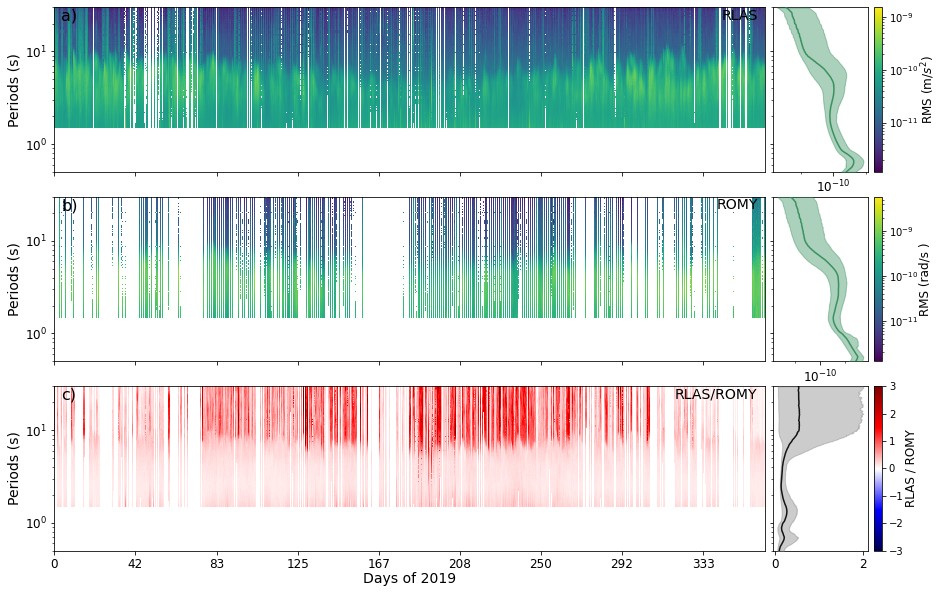

In [27]:
fig = __makeplot_image_overview2([ff_ACC, ff_ROT, ff_ratio], 
                                 [ACC_rms, ROT_rms, rms_ratio], 
                                 [times_ACC, times_ROT, times_ratio], 
                                )

In [28]:
__savefig(fig, outpath=config['outpath_figures'], outname=f"{name_acc}_{name_rot}_psdimage_octave", mode="png", dpi=300)


   -> saving /import/kilauea-data/VelocityChanges/figures/RLAS_ROMY_psdimage_octave.png ...

   -> Done



In [29]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

In [30]:
def __remove_nan(arr, times):
    
    from numpy import nan, array

    a, t, idx = [], [], []
    for ii, (aa, tt) in enumerate(zip(arr, times)):
        if str(aa) != "nan":
            a.append(aa)
            t.append(tt)
        else:
            a.append(0)
            t.append(tt)
            idx.append(ii)
    return array(a), array(t), idx

In [31]:
# from numpy import searchsorted

# frequencies = ff_ACC
# times = times_ACC

# p_selection = array([2,3,5,7,10, 12, 15])
# f_selection = 1/p_selection

# smoothing = 48  ## hours

# font = 14

# samples = []
# for freq in f_selection:
    
#     ## get index to closest frequency 
#     idx = searchsorted(frequencies, freq)

#     ## select according rms array
#     rms_tmp = rms_ratio_rel[:, idx:idx+1]
#     arr = array([s[0] for s in rms_tmp])

#     arr, tt, idx = __remove_nan(arr, times)

#     samples.append(arr)

# fig, ax = plt.subplots(figsize=(15,10))

# offset = 0
# offsets, labels = [], []
# for ii, aa in enumerate(samples):
    
    
    
#     arr_smooth = __smooth(aa, smoothing)
    
#     for jj in idx:
#         arr_smooth[jj] = nan
    
# #     plt.scatter(tt, array(aa)+ii*100, alpha=0.4, s=2)

#     ax.plot(tt/24, arr_smooth+offset, alpha=0.9, label=f"{round(p_selection[ii], 2)} sec", zorder=3)
#     ax.fill_between(tt/24, offset, arr_smooth+offset, alpha=0.5, zorder=3)
    
# #     plt.plot([0, 8670], [ii,ii], 'k--', alpha=0.5, zorder=0)

#     labels.append(f"{round(p_selection[ii], 2)} sec")
#     offsets.append(offset)
    
#     offset += 3 
    
# ax.set_yticks(offsets)
# ax.set_yticklabels(labels, fontsize=font)

# ax.set_xlabel("Days of 2019", fontsize=font)

# plt.title(f"{name_acc} & {name_rot}", fontsize=font+2)
# # plt.legend()
# plt.ylim(-2,25)
# plt.show();

In [32]:
# __savefig(fig, outpath=config['outpath_figures'], outname=f"{name_acc}_{name_rot}_selection", mode="png", dpi=300)

## OLD

In [33]:
def __makeplot_image(ff, psds, times, dates=None):
    
    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors


    ##____________________________
        
    fig, axes = plt.subplots(1, 1, figsize=(12,8), sharey=False, sharex=False)

    plt.subplots_adjust(hspace=0.1)
    
    font = 14

    N = int(24*365)

    
    cmap = plt.cm.get_cmap('rainbow')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')
    
    
    max_psds = nanmax(psds)
    min_psds = nanmin(psds)

    im = axes.pcolormesh(times, 1/array(ff), psds.T, 
                            cmap=cmap,
                            vmax=max_psds,
                            vmin=min_psds,
                            norm=colors.LogNorm(),
                            )

    axes.tick_params(labelsize=font-2)


    axes.set_ylim(config['period_limits'][0], config['period_limits'][1])
    axes.set_yscale("log")

    ## set colorbar at bottom
    cbar = fig.colorbar(im, orientation='vertical', ax=axes.ravel().tolist(), aspect=30, pad=0.01)
    cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-53)

    axes.set_xlabel("Days of 2019", fontsize=font, labelpad=-1)

    new_ticks = [int(round(t/24,0)) for t in axes.get_xticks()]
    axes.set_xticklabels(new_ticks)
    
    ## panel labels
    axes.text(.01, .99, 'a)', ha='left', va='top', transform=axes.transAxes, fontsize=font+2)
    
    ## data labels
    array = name.split("_")[0]
      
    axes.set_ylabel(r"Periods (s)", fontsize=font)
    
    plt.show();    
    return fig

In [34]:
# nn = 500

# fig = __makeplot_image(times_N[:nn], ff_N, ADR_N[:nn,:])

# fig = __makeplot_image(times_Z, ff_Z, ADR_Z)

In [35]:
def __makeplot_image_overview(ff, psds, times, one_colorbar=False):
    
    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors

    
    ## theoretical rlnm
#     rlnm = read_csv(config['rlnm_model_path']+"rlnm_theory.csv")

    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)
        
    ##____________________________
    
    NN = 3
    
    fig, axes = plt.subplots(NN, 1, figsize=(12,12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)
    
    font = 14

    N = int(24*365)
    
    if one_colorbar:
        max_psds = max(nanmax(psds[0]), nanmax(psds[1]), nanmax(psds[2]))
        min_psds = min(nanmin(psds[0]), nanmin(psds[1]), nanmin(psds[2]))
    
    cmap = plt.cm.get_cmap('rainbow')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')
    cmap.set_bad(color='white')
    
    
    for j in tqdm(range(NN)):
        
        if not one_colorbar:
            max_psds = nanmax(psds[j])
            min_psds = nanmin(psds[j])
            
        if j == 2:
            im = axes[j].pcolormesh(times[j], 1/ff[j], psds[j].T, 
                                    cmap=cmap,
                                    vmax=max_psds*1e-1,
                                    vmin=min_psds*1e1,
                                    norm=colors.LogNorm(),
                                    )
            
        else:
            
            im = axes[j].pcolormesh(times[j], 1/ff[j], psds[j].T, 
                                    cmap=cmap,
                                    vmax=max_psds,
                                    vmin=min_psds,
                                    norm=colors.LogNorm(),
                                    )

        axes[j].tick_params(labelsize=font-2)
        

        axes[j].set_ylim(config['period_limits'][0], config['period_limits'][1])
        axes[j].set_yscale("log")

        if not one_colorbar:
            ## set individual colorbars
            cbar = fig.colorbar(im, orientation='vertical', ax=axes[j], aspect=15, pad=0.01)
            cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-50)
        
    axes[NN-1].set_xlabel("Days of 2019", fontsize=font, labelpad=-1)

    new_ticks = [int(round(t/24,0)) for t in axes[NN-1].get_xticks()]
    axes[NN-1].set_xticklabels(new_ticks)
    
    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)
    
    ## data labels
    array = name.split("_")[0]
    axes[0].text(.99, .99, f'FUR$', ha='right', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.99, .99, f'ROMY Z', ha='right', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.99, .99, f'Ratio', ha='right', va='top', transform=axes[2].transAxes, fontsize=font)
    
    
    axes[0].set_ylabel(r"Periods (s)", fontsize=font)
    axes[1].set_ylabel(r"Periods (s)", fontsize=font)
    axes[2].set_ylabel(r"Periods (s)", fontsize=font)
    
    if one_colorbar:
        ## set joint colorbar
        cbar = fig.colorbar(im, orientation='vertical', ax=axes.ravel().tolist(), aspect=30, pad=0.01)
        cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-53)

    plt.show();    
    return fig

In [36]:
# fig = __makeplot_image_overview([ff_FUR_Z, ff_ROMY_Z, ff_FUR_Z], 
#                                 [FUR_Z_rms, ROMY_Z_rms, rms_ratio], 
#                                 [times_FUR_Z, times_ROMY_Z, times_FUR_Z], 
#                                 one_colorbar=False,
#                                 )

In [37]:
# __savefig(fig, outpath=config['outpath_figures'], outname=f"FUR_ROMY_psdimage_final", mode="png", dpi=300)